In [ ]:
import sys
from pathlib import Path

project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rvp import AllocationData, AllocationProblem
from rvp.utilities import PartitionedUtility
from rvp.constraints import CoverageConstraint
from rvp.policies import RankingPolicy
from rvp.comparison import LeverComparison, plot_welfare_curve
from rvp.levers import PredictionImprovementLever, ExpandCoverageLever, UtilityValueLever


## Motivating Example

In [4]:
data_raw = pd.read_csv('../../data/ltu-prediction/ltu_data.csv')
data = AllocationData(df = data_raw)
policy = RankingPolicy()
utility = PartitionedUtility(thresholds=[0.85], values=[0, 1], threshold_type='percentile')

In [6]:
capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=4
)

prediction_lever = PredictionImprovementLever(
    name="Prediction Improvement",
    error_reduction=0.15
)

prediction_women_lever = PredictionImprovementLever(
    name="Predictions for Subgroup",
    error_reduction=0.15,
    covariate_mask=lambda df: ((df['frau'] == '1Female')).astype(int).values
)

(0.0, 3.7010142131045805)

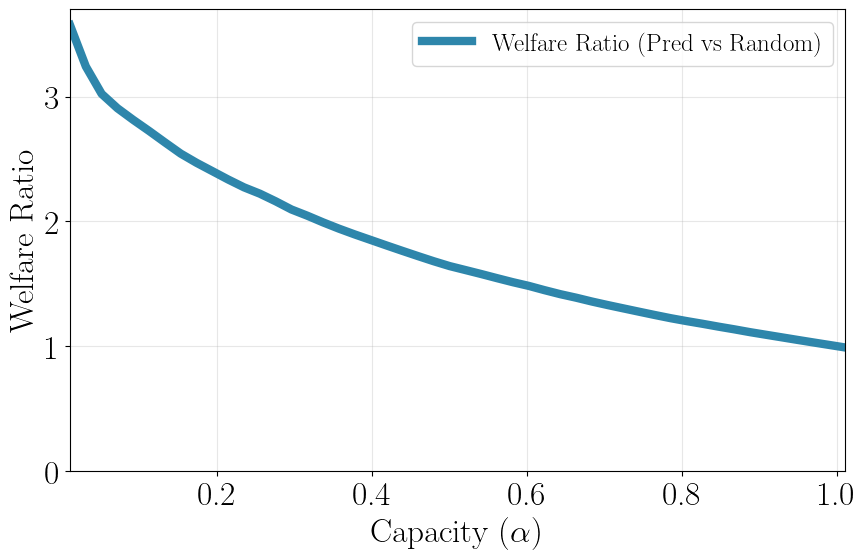

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(figsize=(10, 6))


constraint = CoverageConstraint(max_coverage=0.01, population_size=data.n)


problem = AllocationProblem(data = data,
                            utility = utility, 
                            constraint = constraint,
                            policy=policy)

# All individuals
plot_welfare_curve(
    problem=problem,
    lever=capacity_lever,
    theta_range=(1e-6, 1.0),
    ax=ax,
    xlabel='Capacity Increase (pp)',
    ylabel='Welfare Ratio',
    # color='#F18F01',
    label='Welfare Ratio (Pred vs Random)',
    subgroup_mask=None,
    linestyle='-',
    welfare_metric='utility_ratio',
    show_baseline=True
)


ax.legend(fontsize=18)
baseline_alpha = problem.constraint.get_capacity() / problem.data.n
capacities = np.arange(0.2, 1.01, 0.2)
thetas = capacities - baseline_alpha

ax.set_xticks(thetas)
ax.set_xticklabels([f'{c:.1f}' for c in capacities])

ax.set_xlabel(r'Capacity ($\alpha$)')
ax.set_ylim(bottom=0)

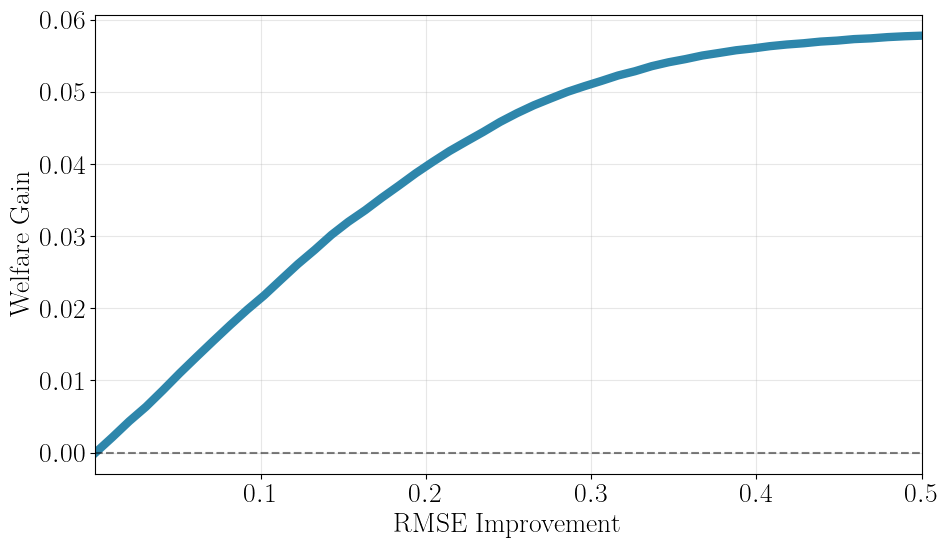

In [10]:
constraint = CoverageConstraint(max_coverage=0.1, population_size=data.n)
problem = AllocationProblem(data = data,
                            utility = utility, 
                            constraint = constraint,
                            policy=policy)



ax = plot_welfare_curve(
    problem=problem,
    lever=prediction_lever,
    theta_range=(1e-6, 0.5),
    xlabel='RMSE Improvement',
    label='Welfare Gain (Population)',
    subgroup_mask=None,
    linestyle='-',
    welfare_metric='mean_utility'
)


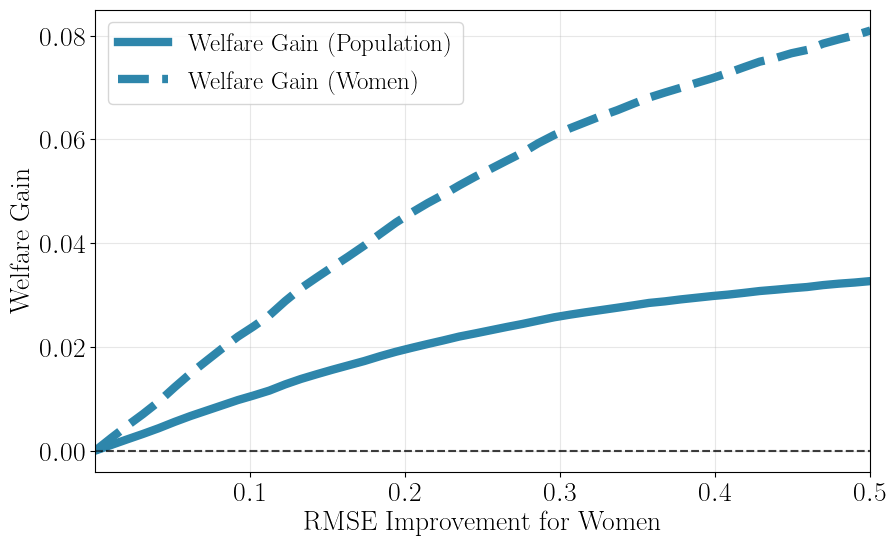

In [12]:
constraint = CoverageConstraint(max_coverage=0.1, population_size=data.n)
problem = AllocationProblem(data = data,
                            utility = utility, 
                            constraint = constraint,
                            policy=policy)


subgroup_mask = data.df['frau'] == '1Female'

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(figsize=(10, 6))

# All individuals
plot_welfare_curve(
    problem=problem,
    lever=prediction_women_lever,
    theta_range=(1e-6, 0.5),
    xlabel='RMSE Improvement for Women',
    #ylim_max=8000,
    ax=ax,
    label='Welfare Gain (Population)',
    subgroup_mask=None,
    linestyle='-',
    welfare_metric='mean_utility'
)

# Women
plot_welfare_curve(
    problem=problem,
    lever=prediction_women_lever,
    theta_range=(1e-6, 0.5),
    xlabel='RMSE Improvement for Women',
    #ylim_max=8000,
    ax=ax,
    label='Welfare Gain (Women)',
    subgroup_mask=subgroup_mask,
    linestyle='--',
    welfare_metric='mean_utility'
)


ax.legend(fontsize=18, loc='upper left')

## Is collecting missing employment history worth the caseworker time?

In [14]:
data_raw = pd.read_csv('../../data/ltu-prediction/ltu_data.csv')
data = AllocationData(df = data_raw)

utility = PartitionedUtility(thresholds=[0.85], values=[0, 1], threshold_type='percentile')
constraint = CoverageConstraint(max_coverage=0.15, population_size=data.n)

problem = AllocationProblem(data=data,
                            utility=utility,
                            constraint=constraint,
                            policy=RankingPolicy())

In [16]:
prediction_subgroup_lever = PredictionImprovementLever(
    name="Predictions for Subgroup",
    error_reduction=0.15,
    covariate_mask=lambda df: ((df['lastjob_none'] == 1) & (df['age'] > 35)).astype(int).values
)

capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=4
)

capacity_lever = capacity_lever.for_budget(problem=problem, budget=2322)

In [17]:
comparison = LeverComparison(problem=problem, lever_a=prediction_subgroup_lever, lever_b=capacity_lever)

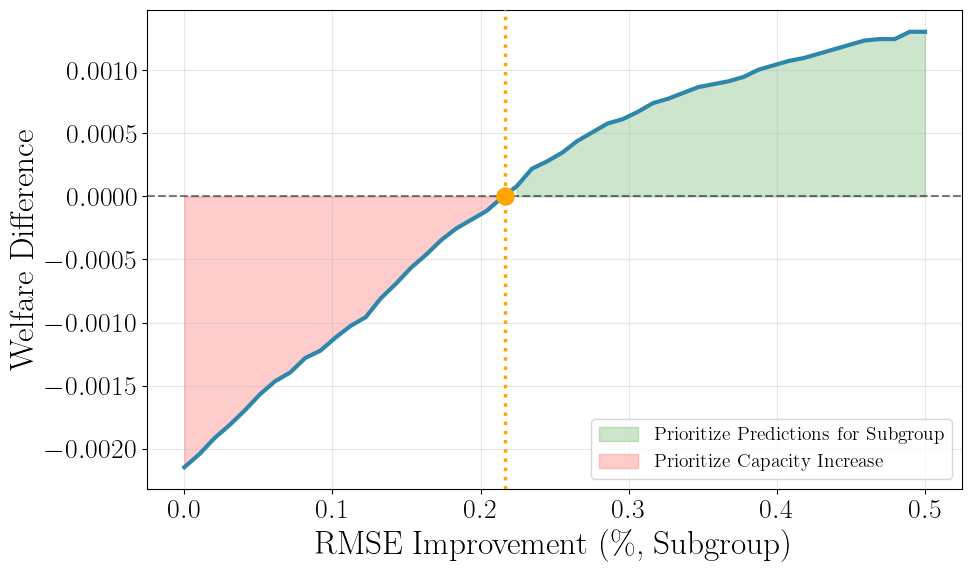

In [18]:
ax = comparison.plot_welfare_difference(theta_range = [0, 0.5], swept_lever='a',
                                        welfare_metric='mean_utility',
                                        xlabel='RMSE Improvement (\%, Subgroup)')

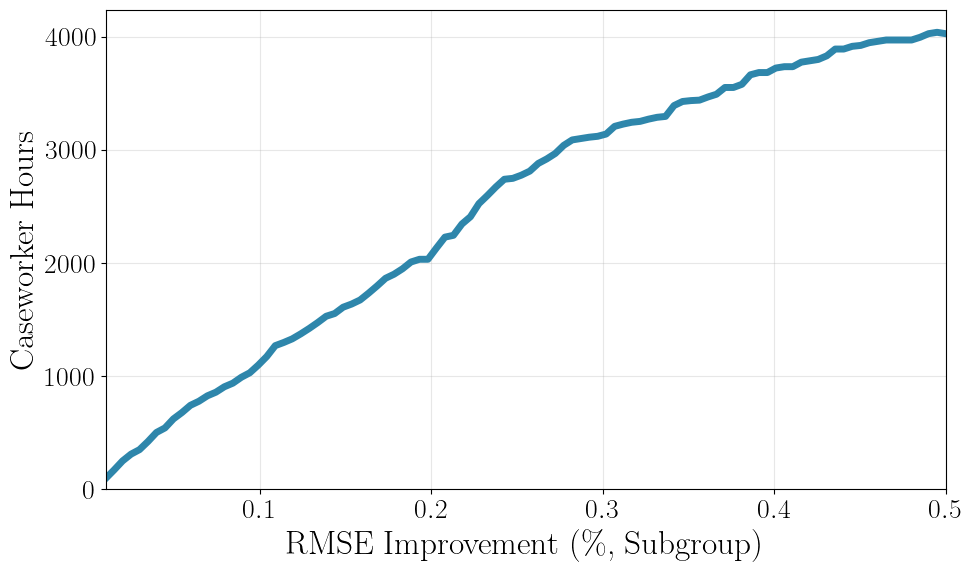

In [19]:
ax = comparison.plot_equivalent_cost(theta_range = [0.01, 0.5], swept_lever='a',
                                     reference_theta_search_range=[1e-6, 1.0],
                                     xlabel='RMSE Improvement (\%, Subgroup)',
                                     ylabel='Caseworker Hours',
                                     n_points=100)

In [20]:
prediction_subgroup_threshold_lever = PredictionImprovementLever(
    name="Predictions for Subgroup (at Threshold)",
    error_reduction=0.15,
    prediction_range=[0.75, 0.95],
    covariate_mask=lambda df: ((df['lastjob_none'] == 1) & (df['age'] > 35)).astype(int).values
)

capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=4
)

capacity_lever = capacity_lever.for_budget(problem=problem, budget=693)

comparison_at_threshold = LeverComparison(problem=problem, lever_a=prediction_subgroup_threshold_lever, lever_b=capacity_lever)

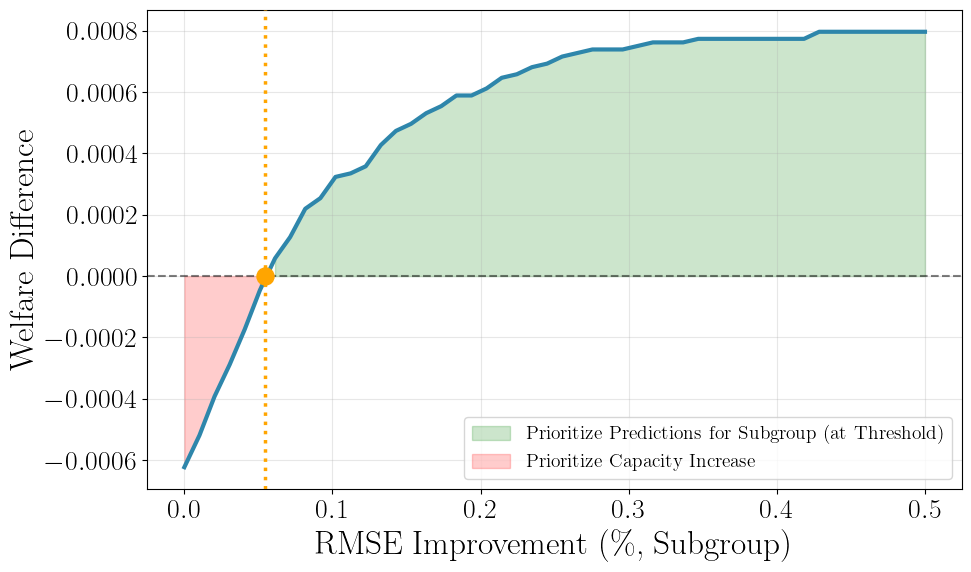

In [21]:
ax = comparison_at_threshold.plot_welfare_difference(theta_range = [0, 0.5], swept_lever='a',
                                    welfare_metric='mean_utility',
                                   xlabel='RMSE Improvement (\%, Subgroup)')

## Allocating Goods and Harms

In [23]:
data_raw = pd.read_csv('../../data/ltu-prediction/ltu_data.csv')
data = AllocationData(df = data_raw)

utility = PartitionedUtility(thresholds=[0.75], values=[-2, 1], threshold_type='percentile')
constraint = CoverageConstraint(max_coverage=0.01, population_size=data.n)

problem = AllocationProblem(data=data,
                            utility=utility,
                            constraint=constraint,
                            policy=RankingPolicy(min_utility=0.))

In [24]:
harm_lever = UtilityValueLever(
    name="Misallocation cost (h)",
    value_index=0,
    new_value=-1,  # starting value
)

capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=4
)

prediction_lever = PredictionImprovementLever(
    name="Predictions",
    error_reduction=0.5,
)

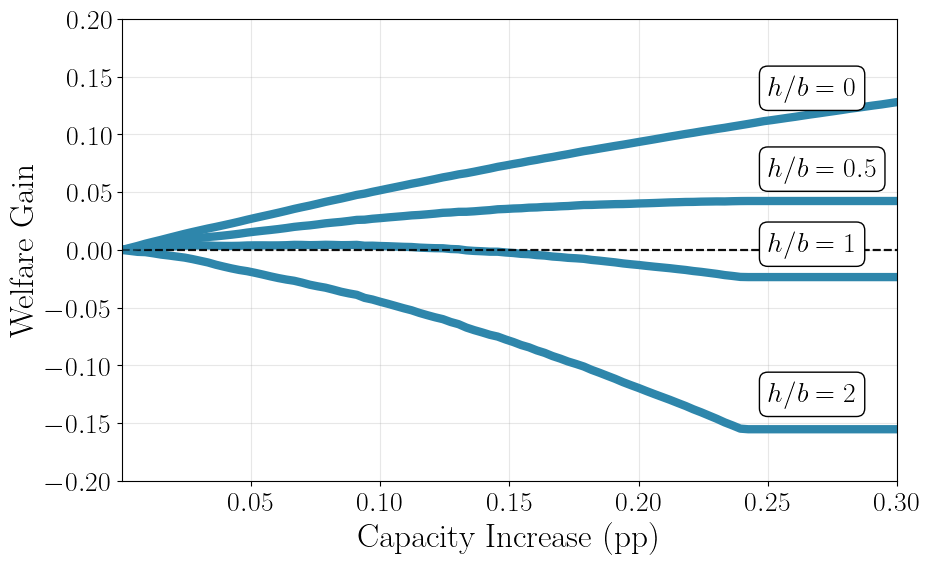

In [26]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(figsize=(10, 6))

for harm_value in [-2, -1, -0.5, 0]:
    lever = harm_lever.with_theta(harm_value)
    modified_problem = lever.apply(problem)
    
    plot_welfare_curve(
        problem=modified_problem,
        lever=capacity_lever,
        theta_range=(1e-6, 0.3),
        ax=ax,
        xlabel='Capacity Increase (pp)',
        n_points=100,
        welfare_metric='mean_utility',
    )
ax.set_ylim(bottom=-0.2000, top=0.2000)

annotations = [
    (0.25, 0.14000, r'$h/b = 0$', 3),
    (0.25, 0.07, r'$h/b = 0.5$', 2),
    (0.25, 0.005, r'$h/b = 1$', 1),
    (0.25, -0.12500, r'$h/b = 2$', 0),
]

for x, y, label, line_idx in annotations:
    ax.text(x, y, label,
            fontsize=20, ha='left', va='center',
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', 
                      facecolor='white', 
                      edgecolor='black',
                      alpha=1))

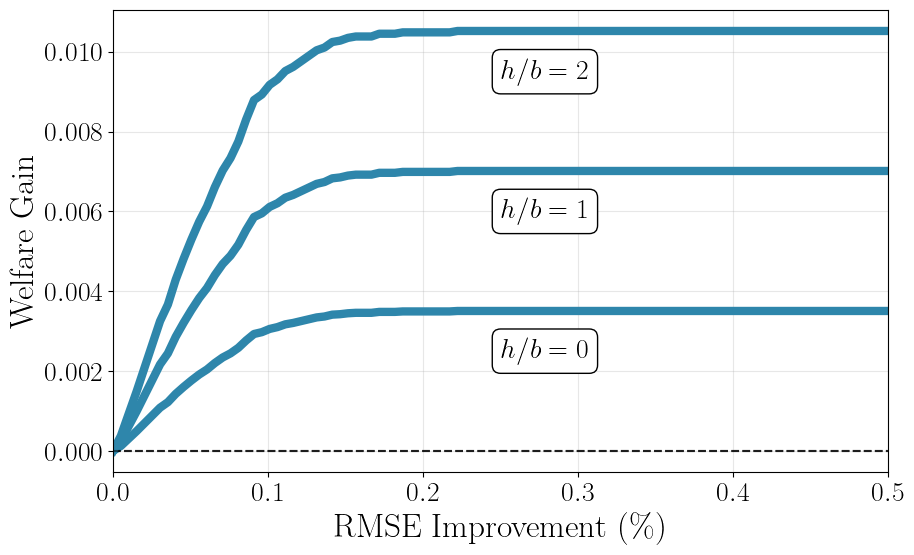

In [27]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(figsize=(10, 6))

for harm_value in [0, -1, -2]:
    # Modify utility with harm value
    harm_lever_at_h = harm_lever.with_theta(harm_value)
    modified_problem = harm_lever_at_h.apply(problem)
    
    # Plot welfare curve for prediction improvement
    plot_welfare_curve(
        problem=modified_problem,
        lever=prediction_lever,  # PredictionImprovementLever
        theta_range=(0, 0.5),      # theta = fraction of error corrected
        ax=ax,
        xlabel='RMSE Improvement (\%)',
        ylabel='Welfare Gain',
        welfare_metric='mean_utility',
        n_points=100
    )

annotations = [
    (0.25, 0.00950, r'$h/b = 2$', 2),
    (0.25, 0.00600, r'$h/b = 1$', 1),
    (0.25, 0.00250, r'$h/b = 0$', 0),
]

for x, y, label, line_idx in annotations:
    ax.text(x, y, label,
            fontsize=20, ha='left', va='center',
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', 
                      facecolor='white', 
                      edgecolor='black',
                      alpha=1))

[Text(0, -1.9, '0.05'),
 Text(0, -1.5, '0.25'),
 Text(0, -1.0, '0.5'),
 Text(0, -0.5, '0.75')]

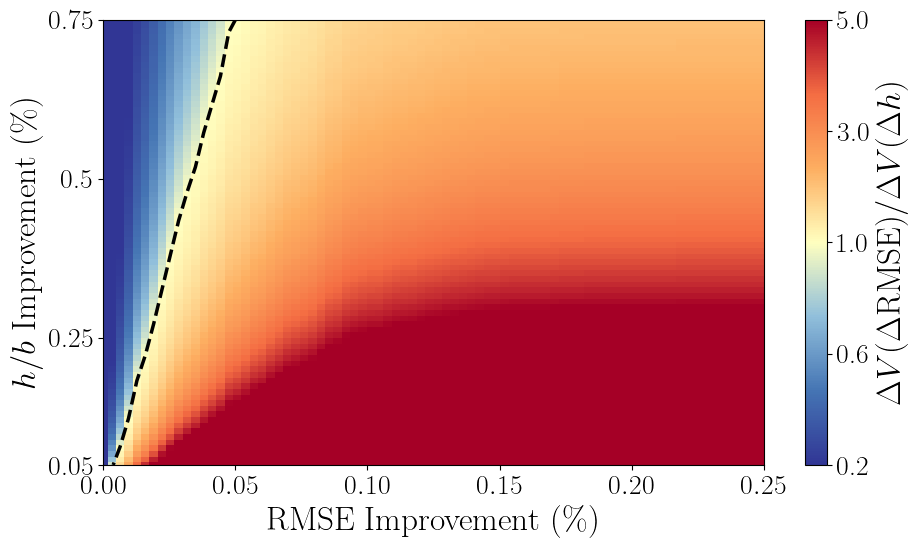

In [29]:
utility = PartitionedUtility(thresholds=[0.75], values=[-2, 1], threshold_type='percentile')
constraint = CoverageConstraint(max_coverage=0.01, population_size=data.n)

problem = AllocationProblem(data=data,
                            utility=utility,
                            constraint=constraint,
                            policy=RankingPolicy(min_utility=0.))

comparison = LeverComparison(
    problem=problem,
    lever_a=prediction_lever,
    lever_b=harm_lever,
)

ax = comparison.plot_welfare_heatmap(
    theta_a_range=(0, 0.25),      # prediction improvement
    theta_b_range=(-1.9, -0.5),     
    xlabel='RMSE Improvement (\%)',
    ylabel=r'$h/b$ Improvement (\%)',
    cmap=None,              # red-yellow-green
    vmin = 0.2,
    vmax = 5,
    figsize=(10, 6),
    n_points_a=80,
    n_points_b=80,
    colorbar_label=r'$\Delta V(\Delta$RMSE$)  /  \Delta V(\Delta h)$'
)

baseline_hb = 2.0
yticks = [-1.9, -1.5, -1.0, -0.5]
reduction = [(baseline_hb - (-t)) / baseline_hb for t in yticks]

ax.set_yticks(yticks)
ax.set_yticklabels([f'{p:.2g}' for p in reduction])
